## Web Scraping using BeautifulSoup on Game of thrones series reviews

### Let us perform web scrapping of reviews from Imdb of Game of thrones. <br> The reviews can be accessed at https://www.imdb.com/title/tt0944947/reviews

<img src="got2.jpg">

#### We will first scrape the reviews and then using NLP and machine learning perform sentiment analysis on it. 

#Importing the required libraries and extracting the Movie reviews and their ratings

In [1]:
from bs4 import BeautifulSoup

In [2]:
#I have saved the reviews on a html page 
soup = BeautifulSoup(open("1.html",encoding="utf8"), "html.parser")

#### Let us take a look at the html structure 

In [3]:
got_containers = soup.find_all('div' , class_ = 'review-container')
print(type(got_containers))
print(len(got_containers))

<class 'bs4.element.ResultSet'>
1124


#### We can see there are 1124 containers consisting of the reviews and the ratings, let us try to extract this information!

In [4]:
first_got = got_containers[0]
first_got.a.text

" Finally, a Show that stays true to it's written roots\n"

#### By carefully looking at the html structure we try to access the reviews, Let us try to find the ratings of the reviews

In [5]:
rating = first_got.span.text
rating

'\n\n\n\n\n\n9/10\n'

#### We are able to access the elements, this can be used in an iterator to obtain all the reviews and the ratings. <br> We can see that the reviews and ratings require cleaning which we will deal later.

In [6]:
# Lists to store the scraped data in
reviews = []
ratings = []

# Extract data from individual movie container
for container in got_containers:
    
    #review
    review = container.a.text
    reviews.append(review)
    
    #rating
    rating = container.span.text
    ratings.append(rating)

#### Let us put all the ratings and reviews in a dataframe

In [7]:
import pandas as pd
import numpy as np
test_df = pd.DataFrame({'Review': reviews,'Rating': ratings})
print(test_df.info())
test_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1124 entries, 0 to 1123
Data columns (total 2 columns):
Review    1124 non-null object
Rating    1124 non-null object
dtypes: object(2)
memory usage: 17.6+ KB
None


,Review,Rating
0,"Finally, a Show that stays true to it's writt...",\n\n\n\n\n\n9/10\n
1,Excellent adaptation.\n,\n\n\n\n\n\n10/10\n
2,One of the most stunning shows on television\n,\n\n\n\n\n\n10/10\n
3,Lord of the Rings - I think not!\n,\n\n\n\n\n\n10/10\n
4,Fantasy has never seemed so real\n,\n\n\n\n\n\n10/10\n


### And voila we have scrapped all the reviews and the ratings <br> Let us perform cleaning on the reviews and the ratings

In [8]:
#Using regular expression to replace character with NaN value as some reviews
import re
def split_it(rating):
    return re.sub('[a-zA-Z]+','NaN', rating)

In [9]:
#Replacing next line seperator with NaN values and then keeping only numeric values
test_df.loc[:, 'Rating'] = test_df['Rating'].str[6:8]
test_df['Rating'] = test_df['Rating'].apply(split_it)
test_df.loc[:, 'Review'] = test_df['Review'].str.replace('\n', '')
test_df.loc[:, 'Rating'] = test_df['Rating'].str.replace('/', '')
test_df.loc[:, 'Rating'] = test_df['Rating'].str.replace('-', '')

In [10]:
test_df = test_df[test_df.Rating.str.contains("NaN") == False]
test_df['Rating'] = test_df['Rating'].apply(pd.to_numeric)

In [11]:
test_df.head()

,Review,Rating
0,"Finally, a Show that stays true to it's writt...",9.0
1,Excellent adaptation.,10.0
2,One of the most stunning shows on television,10.0
3,Lord of the Rings - I think not!,10.0
4,Fantasy has never seemed so real,10.0


### We can see that we have cleaned the Ratings and the Reviews <br> Let us perform Exploratory data analysis

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

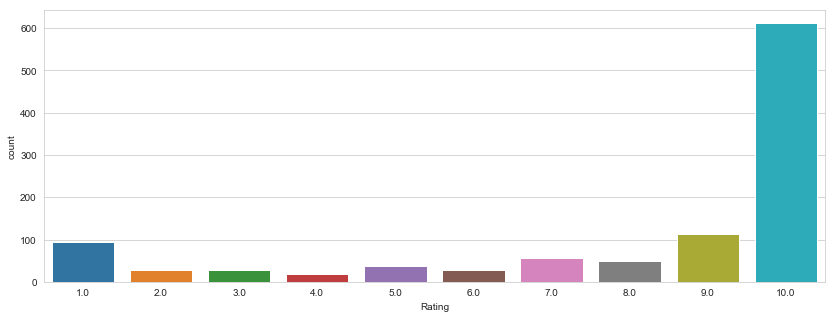

In [13]:
test_df = test_df[test_df.Rating <= 10]

plt.figure(figsize=(14,5))
sns.set_style("whitegrid")
ax = sns.countplot(test_df['Rating'])

In [14]:
#Let us look at the descriptions
test_df.describe()

,Rating
count,1065.000000
mean,8.071362
std,3.015090
min,1.000000
25%,7.000000
50%,10.000000
75%,10.000000
max,10.000000


#### We can see there are 1065 reviews, with the mean rating of 8 and most of the ratings are 10. <br> Let us look if there is a relation between a review length and a Rating.

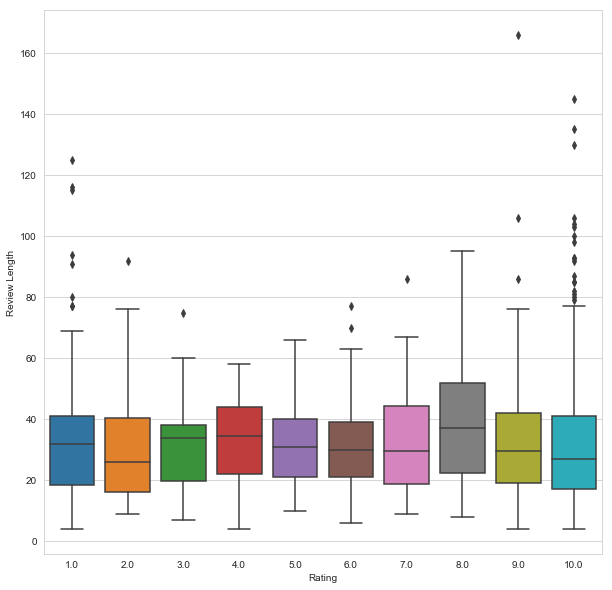

In [15]:
#Let us see if there is a relationship between length of a review and rating 
test_df['Review']=test_df['Review'].astype(str)
test_df['Review Length']=test_df['Review'].apply(len)

plt.figure(figsize=(10,10))
sns.boxplot(x='Rating', y='Review Length', data=test_df)
plt.show()

#### We can see that Reviews with ratings 1 and and 8 are the longest in length!

### Let us try to use NLP and machine learning

In [16]:
#Importing NLP Libraries
from collections import Counter
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
import nltk
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize

In [17]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Akshay\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

#### Let us try to extract all the words and try to perform analysis on it

In [18]:
a = test_df['Review'].str.lower().str.cat(sep=' ')

In [19]:
# removes punctuation,numbers and returns list of words
b = re.sub('[^A-Za-z]+', ' ', a)

In [20]:
#remove all the stopwords from the text
stop_words = list(get_stop_words('en'))         
nltk_words = list(stopwords.words('english'))   
stop_words.extend(nltk_words)

newStopWords = ['game','thrones', 'bran', 'stark', 'dragons']
stop_words.extend(newStopWords)

In [21]:
word_tokens = word_tokenize(b)

#### We have extracted all the words in the reviews. Let us find the total length

In [22]:
len(word_tokens)

6030

#### We will now remove the stop words from the reviews

In [23]:
filtered_sentence = []
for w in word_tokens:
    if w not in stop_words:
        filtered_sentence.append(w)

In [24]:
len(filtered_sentence)

3599

#### We have removed all the stop words and reduced the size by half!

In [25]:
# Remove characters which have length less than 2  
without_single_chr = [word for word in filtered_sentence if len(word) > 2]

# Remove numbers
cleaned_data_title = [word for word in without_single_chr if not word.isnumeric()]   

#### Let us look at the top 10 most used words in a review.

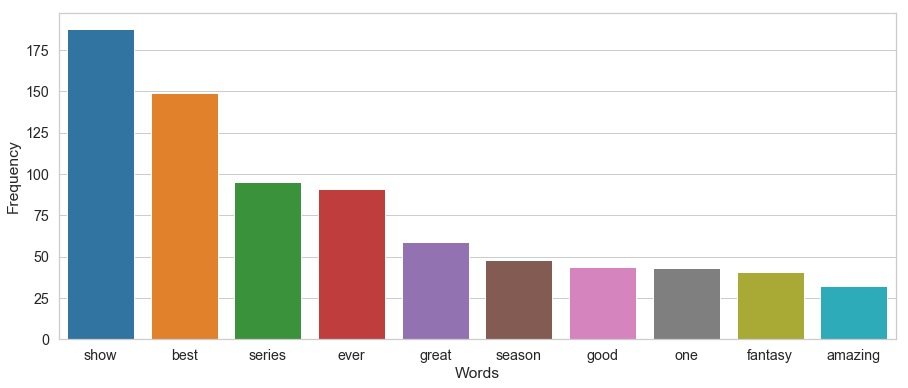

In [26]:
sns.set_context("notebook", font_scale=1.3)
top_N = 100
word_dist = nltk.FreqDist(cleaned_data_title)
rslt = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Words', 'Frequency'])

plt.figure(figsize=(15,6))
sns.set_style("whitegrid")
ax = sns.barplot(x="Words",y="Frequency", data=rslt.head(10))

### We can see that the most common words are positive indicating how great Game of thrones is! <br> Let us visualize this is a word cloud 

In [27]:
from wordcloud import WordCloud, STOPWORDS

In [28]:
def wc(data,bgcolor,title):
    plt.figure(figsize = (100,100))
    wc = WordCloud(background_color = bgcolor, max_words = 1000,  max_font_size = 50)
    wc.generate(' '.join(data))
    plt.imshow(wc)
    plt.axis('off')

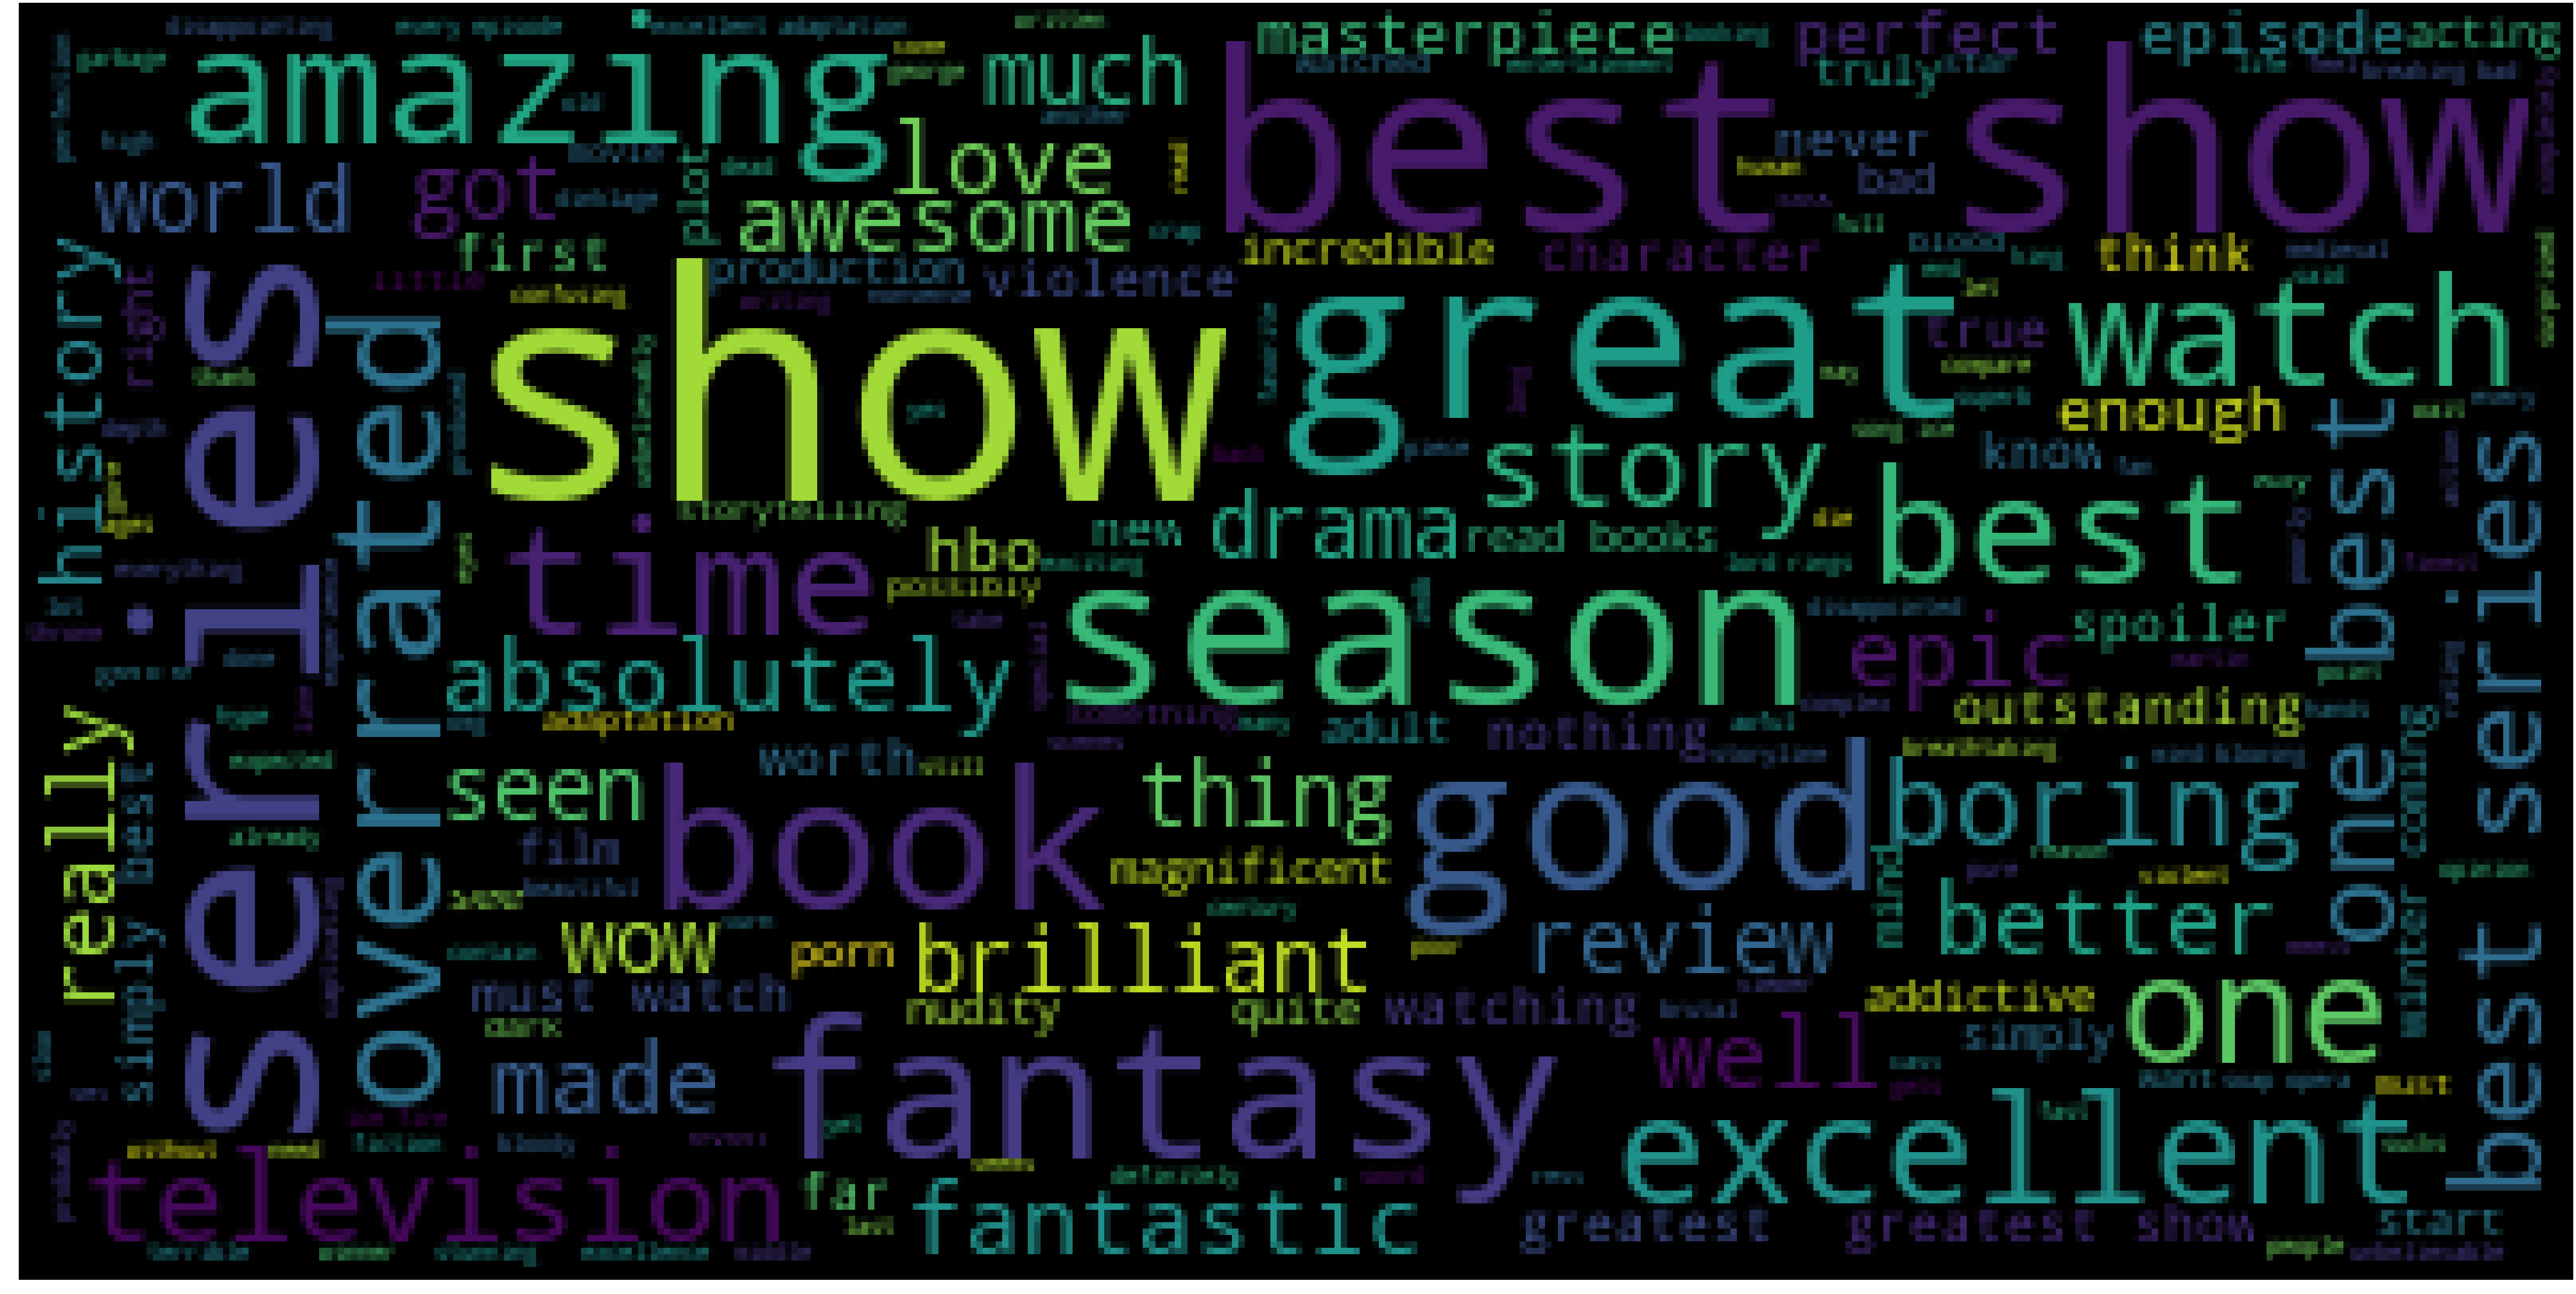

In [29]:
#Let us visualise the most common words
wc(cleaned_data_title,'black','Most Used Words')

### Let us try to perform analysis on the entire review rather than all the words. <br> For this we make use of the TextBlob

In [30]:
from textblob import TextBlob
bloblist_desc = list()
df_review_str=test_df['Review'].astype(str)

In [31]:
for row in df_review_str:
    blob = TextBlob(row)
    bloblist_desc.append((row,blob.sentiment.polarity, blob.sentiment.subjectivity))
    df_polarity_desc = pd.DataFrame(bloblist_desc, columns = ['Review','sentiment','polarity'])

#### We will try to perform sentimental analysis and try to classify whether a review is a positive or negative

In [32]:
df_polarity_desc.head()

,Review,sentiment,polarity
0,"Finally, a Show that stays true to it's writt...",0.175,0.825
1,Excellent adaptation.,1.000,1.000
2,One of the most stunning shows on television,0.500,0.750
3,Lord of the Rings - I think not!,0.000,0.000
4,Fantasy has never seemed so real,0.200,0.300


#### We can see the sentiments of the reviews, if it is close to 1 it means it is a positive review and by looking at the dataset we can set the values like I've set below.

In [33]:
def f(df_polarity_desc):
    if df_polarity_desc['sentiment'] >= 0:
        val = "Positive Review"
    elif df_polarity_desc['sentiment'] >= -0.09:
        val = "Neutral Review"
    else:
        val = "Negative Review"
    return val

#### This is a personal preference which you can change according to your choice.

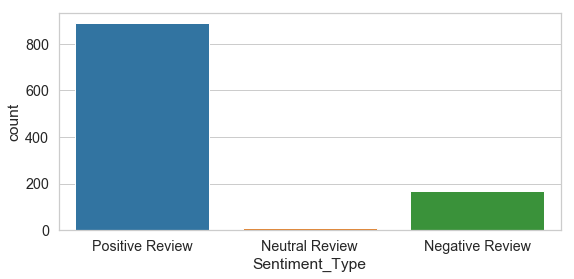

In [34]:
df_polarity_desc['Sentiment_Type'] = df_polarity_desc.apply(f, axis=1)
plt.figure(figsize=(9,4))
ax = sns.countplot(x="Sentiment_Type", data=df_polarity_desc)

#### We can see that we have an unbalanced dataset with mostly positive reviews

In [35]:
positive_reviews=df_polarity_desc[df_polarity_desc['Sentiment_Type']=='Positive Review']
negative_reviews=df_polarity_desc[df_polarity_desc['Sentiment_Type']=='Negative Review']
negative_reviews.head()

,Review,sentiment,polarity,Sentiment_Type
15,Heads up for GAME OF THRONES,-0.400000,0.400000,Negative Review
22,"As expected, some will love it, some will hat...",-0.133333,0.633333,Negative Review
36,Possibly the worst storyline I will ever enco...,-0.500000,1.000000,Negative Review
42,On finding Game of Thrones on VHS,-0.400000,0.400000,Negative Review
43,Unbelievably awful,-1.000000,1.000000,Negative Review


#### Let us look at the most used words in all the positive reviews

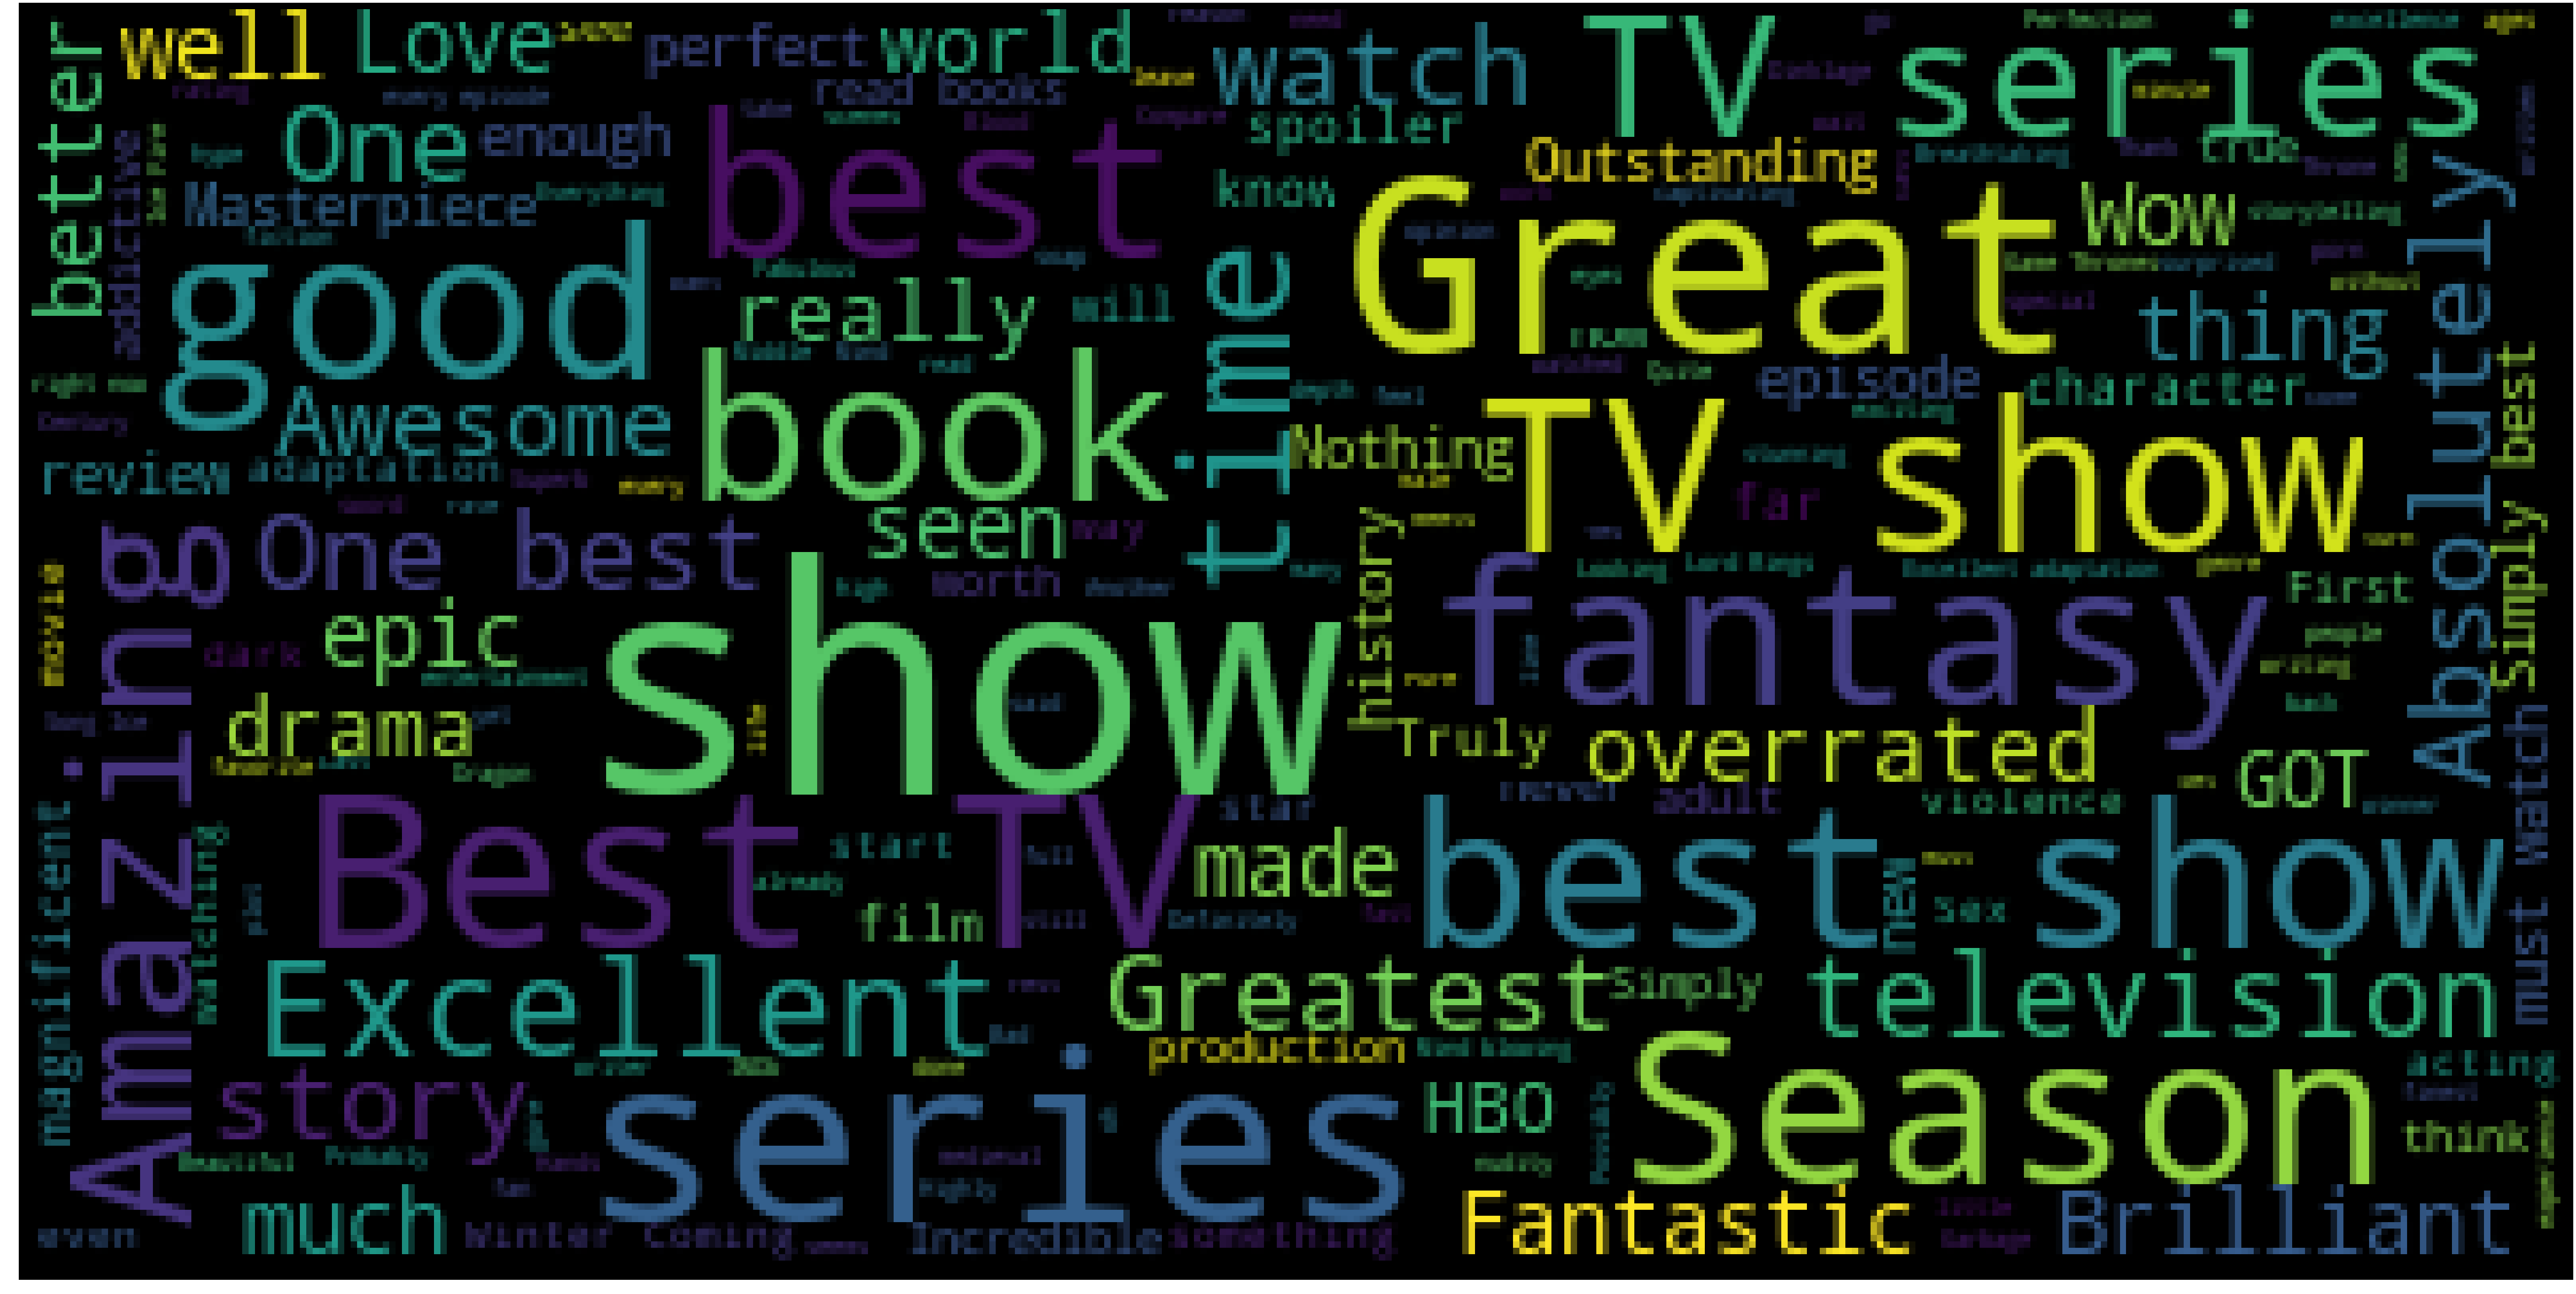

In [36]:
wc(positive_reviews['Review'],'black','Most Used Words')

#### Let us look at the most used words in all the negative reviews

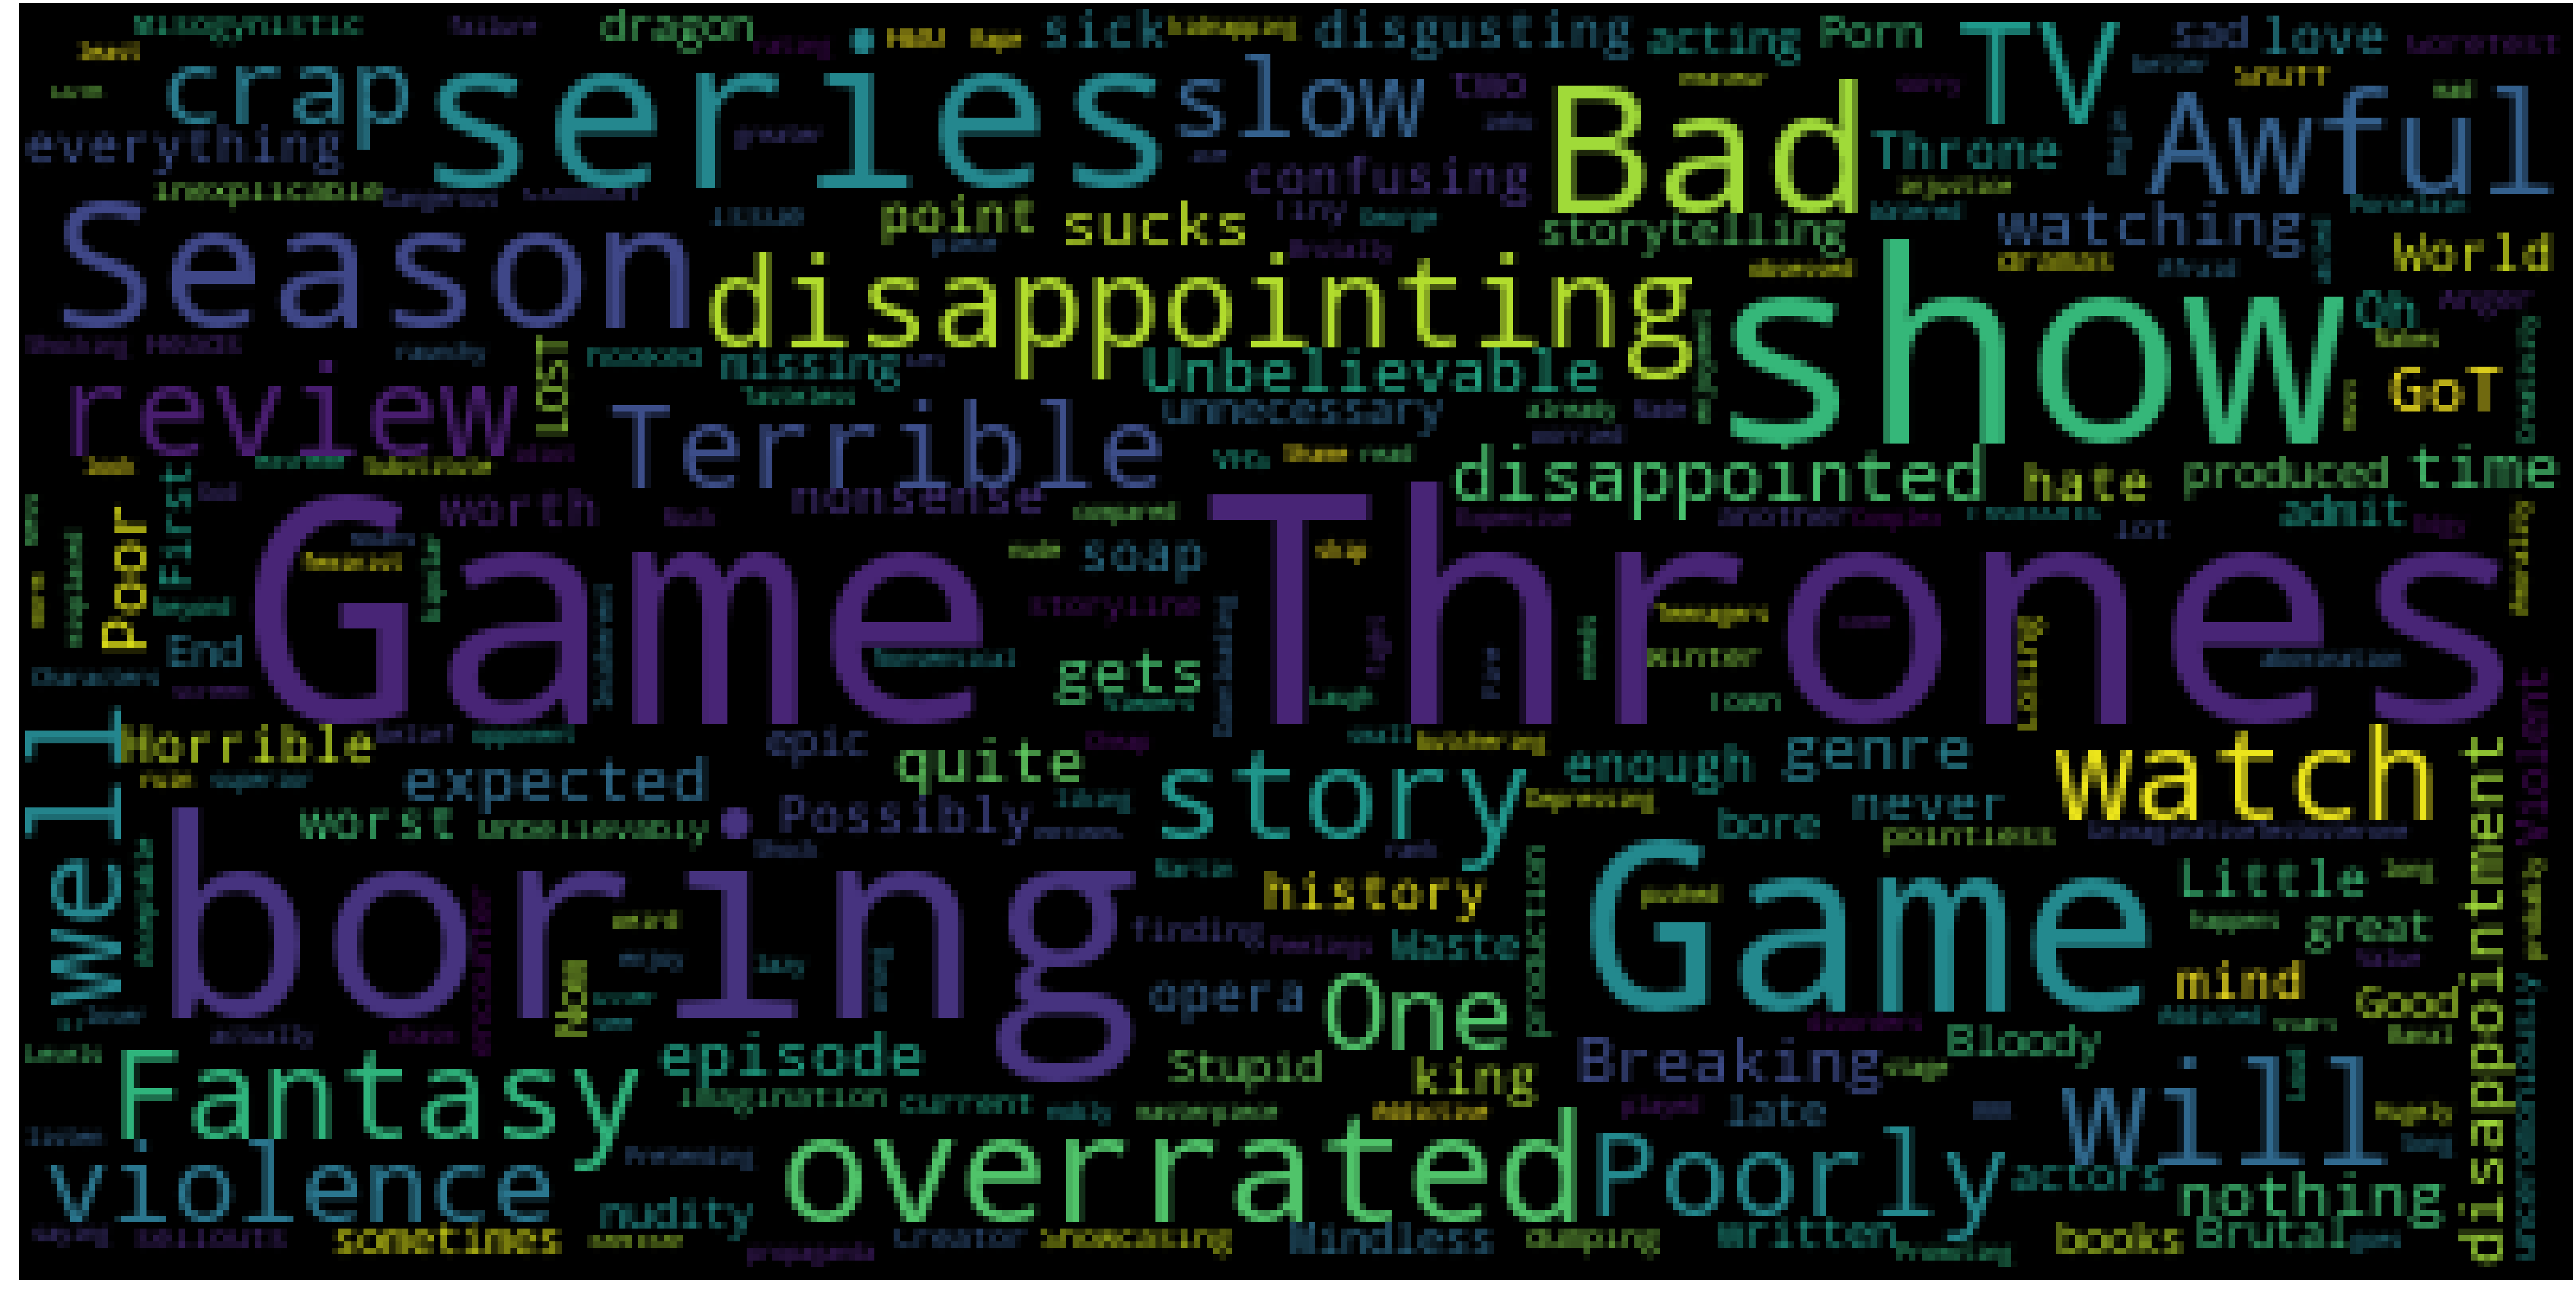

In [37]:
wc(negative_reviews['Review'],'black','Most Used Words')

#### It is hard to believe such people exist in the world 

### Let us trying to train a model to understand the sentiments and then we can try making a predicting using machine learning

In [38]:
import string
def text_process(review):
    nopunc=[word for word in review if word not in string.punctuation]
    nopunc=''.join(nopunc)
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

#### Let us now train a model <br> We are taking only review with ratings 1 and 10 as most of the reviews are either 1 or 10 and to make the analysis more simple.

In [39]:
test_df=test_df.dropna(axis=0,how='any')
rating_class = test_df[(test_df['Rating'] == 1) | (test_df['Rating'] == 10)]
X_review=rating_class['Review']
y=rating_class['Rating']

In [40]:
from sklearn.feature_extraction.text import CountVectorizer
bow_transformer=CountVectorizer(analyzer=text_process).fit(X_review)

#### The CountVectorizer provides a simple way to both tokenize a collection of text documents and build a vocabulary of known words

In [41]:
X_review = bow_transformer.transform(X_review)

In [42]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_review, y, test_size=0.3, random_state=101)

#### Let us train a model using Multinomial Naive Bayes as it works great on text as it assumes all features are equally important and avoids overfitting.

In [43]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train, y_train)
predict=nb.predict(X_test)

#### Let us find the accuracy of our model

In [44]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
print('Accuracy:', round(accuracy_score(y_test, predict)* 100,2),'%')

Accuracy: 81.22 %


#### As seen earlier we have an unbalanced dataset and only accuracy cannot depict if our model is good at prediction. <br> Let us look at the confusion matrix

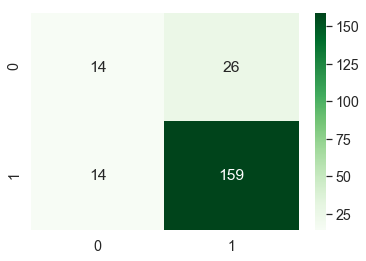

In [45]:
a = confusion_matrix(y_test, predict)
sns.heatmap(a, annot=True,cmap='Greens', fmt='g')
plt.show()

#### We can see that there are a lot of False positive considering the unbalanced dataset with less number of reviews with 1 rating.

In [46]:
print(classification_report(y_test, predict))

              precision    recall  f1-score   support

         1.0       0.50      0.35      0.41        40
        10.0       0.86      0.92      0.89       173

   micro avg       0.81      0.81      0.81       213
   macro avg       0.68      0.63      0.65       213
weighted avg       0.79      0.81      0.80       213



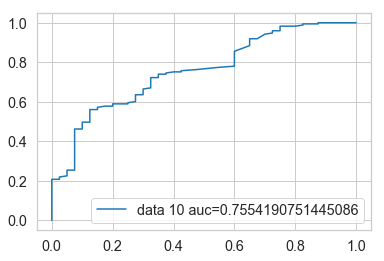

In [47]:
y_pred_proba = nb.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba,pos_label=10)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 10 auc="+str(auc))
plt.legend(loc=4)
plt.show()

#### We have a 81 percent accuracy but a very recall score indicating that movies with ratings 1'sare not classified properly this maybe due to a large ratio of positive review. <br><br>Hence it has a bad recall.


#### Let us try SMOTE to handle the problems caused by imbalanced dataset

In [48]:
from imblearn.over_sampling import SMOTE

In [49]:
print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (494, 1058)
Number transactions y_train dataset:  (494,)
Number transactions X_test dataset:  (213, 1058)
Number transactions y_test dataset:  (213,)


In [50]:
print("Before OverSampling, counts of label '10': {}".format(sum(y_train==10)))
print("Before OverSampling, counts of label '1': {} \n".format(sum(y_train==1)))

sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '10': {}".format(sum(y_train_res==10)))
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))

Before OverSampling, counts of label '10': 439
Before OverSampling, counts of label '1': 55 

After OverSampling, the shape of train_X: (878, 1058)
After OverSampling, the shape of train_y: (878,) 

After OverSampling, counts of label '10': 439
After OverSampling, counts of label '1': 439


### By making using of synthetic minority sampling technique we can have a balanced dataset on which we can perform our predictions, our accuracy might decrease but it will help to improve the classification of reviews with 1 rating! 

In [51]:
nb.fit(X_train_res, y_train_res)
predict_smote=nb.predict(X_test)

#### Let us find the accuracy of our model

In [52]:
print('Accuracy:', round(accuracy_score(y_test, predict_smote)* 100,2),'%')

Accuracy: 70.42 %


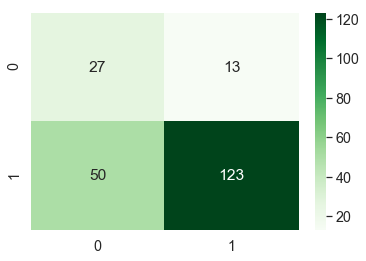

In [53]:
a = confusion_matrix(y_test, predict_smote)
sns.heatmap(a, annot=True,cmap='Greens', fmt='g')
plt.show()

#### We can see that there is a reduction in the number of false positive

In [54]:
print(classification_report(y_test, predict_smote))

              precision    recall  f1-score   support

         1.0       0.35      0.68      0.46        40
        10.0       0.90      0.71      0.80       173

   micro avg       0.70      0.70      0.70       213
   macro avg       0.63      0.69      0.63       213
weighted avg       0.80      0.70      0.73       213



### Although, our overall accuracy has decreased. We have increased the recall to 68 percent. <br><br> Hence our model can classify review with 1 rating better. 

### Let us test our model

In [55]:
rating_positive=test_df['Review'][6]
rating_positive

' This TV series is magnificent!'

In [56]:
rating_postive_transformed = bow_transformer.transform([rating_positive])
nb.predict(rating_postive_transformed)[0]

10.0

In [57]:
rating_negative=test_df['Review'][54]
rating_negative

' disgusting, overrated, pointless'

In [58]:
rating_negative_transformed = bow_transformer.transform([rating_negative])
nb.predict(rating_negative_transformed)[0]

1.0

### Thus we can see the power of natural language processing and how machine learning can be used to perform predictions!